In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
cd /content/drive/My Drive/task_retai/

/content/drive/My Drive/task_retai


In [ ]:
import glob

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
train_folders = sorted(glob('/content/drive/My Drive/task_retai/train/*'))
len(train_folders)

100

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}


In [ ]:
datasets=['train','val','test']

In [ ]:
DATASETS=['train','val','test']
DATA_DIR = '/content/drive/My Drive/task_retai/data/'

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

In [ ]:
data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

{'test': 379, 'train': 1924, 'val': 284}

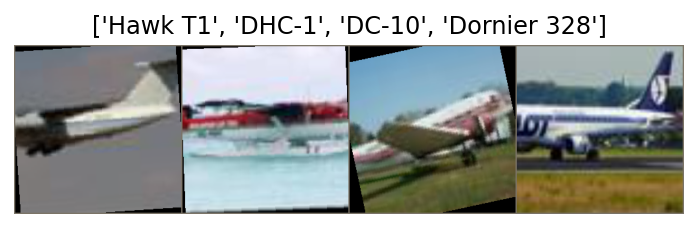

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)
  return model.to(device)

In [ ]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  scheduler.step()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=500):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)
  history = defaultdict(list)
  best_accuracy = 0
  for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc
  print(f'Best val accuracy: {best_accuracy}')
  model.load_state_dict(torch.load('best_model_state.bin'))
  return model, history

In [ ]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/500
----------
Train loss 3.607516442415868 accuracy 0.1023908523908524
Val   loss 3.5022054104737834 accuracy 0.17253521126760563

Epoch 2/500
----------
Train loss 3.408919229081168 accuracy 0.14397089397089397
Val   loss 3.3136800174981778 accuracy 0.2007042253521127

Epoch 3/500
----------
Train loss 3.1785478797623123 accuracy 0.19126819126819128
Val   loss 3.248355751306238 accuracy 0.2605633802816901

Epoch 4/500
----------
Train loss 3.0388678817887813 accuracy 0.21413721413721415
Val   loss 3.5067462367071234 accuracy 0.2323943661971831

Epoch 5/500
----------
Train loss 2.9289166642325832 accuracy 0.23804573804573806
Val   loss 3.659332020182005 accuracy 0.24295774647887325

Epoch 6/500
----------
Train loss 2.8025585772341848 accuracy 0.2655925155925156
Val   loss 3.2508132659213644 accuracy 0.2711267605633803

Epoch 7/500
----------
Train loss 2.6838153440838295 accuracy 0.30405405405405406
Val   loss 3.1701995931880576 accuracy 0.31690140845070425

Epoch 8/500
----

# TESTING

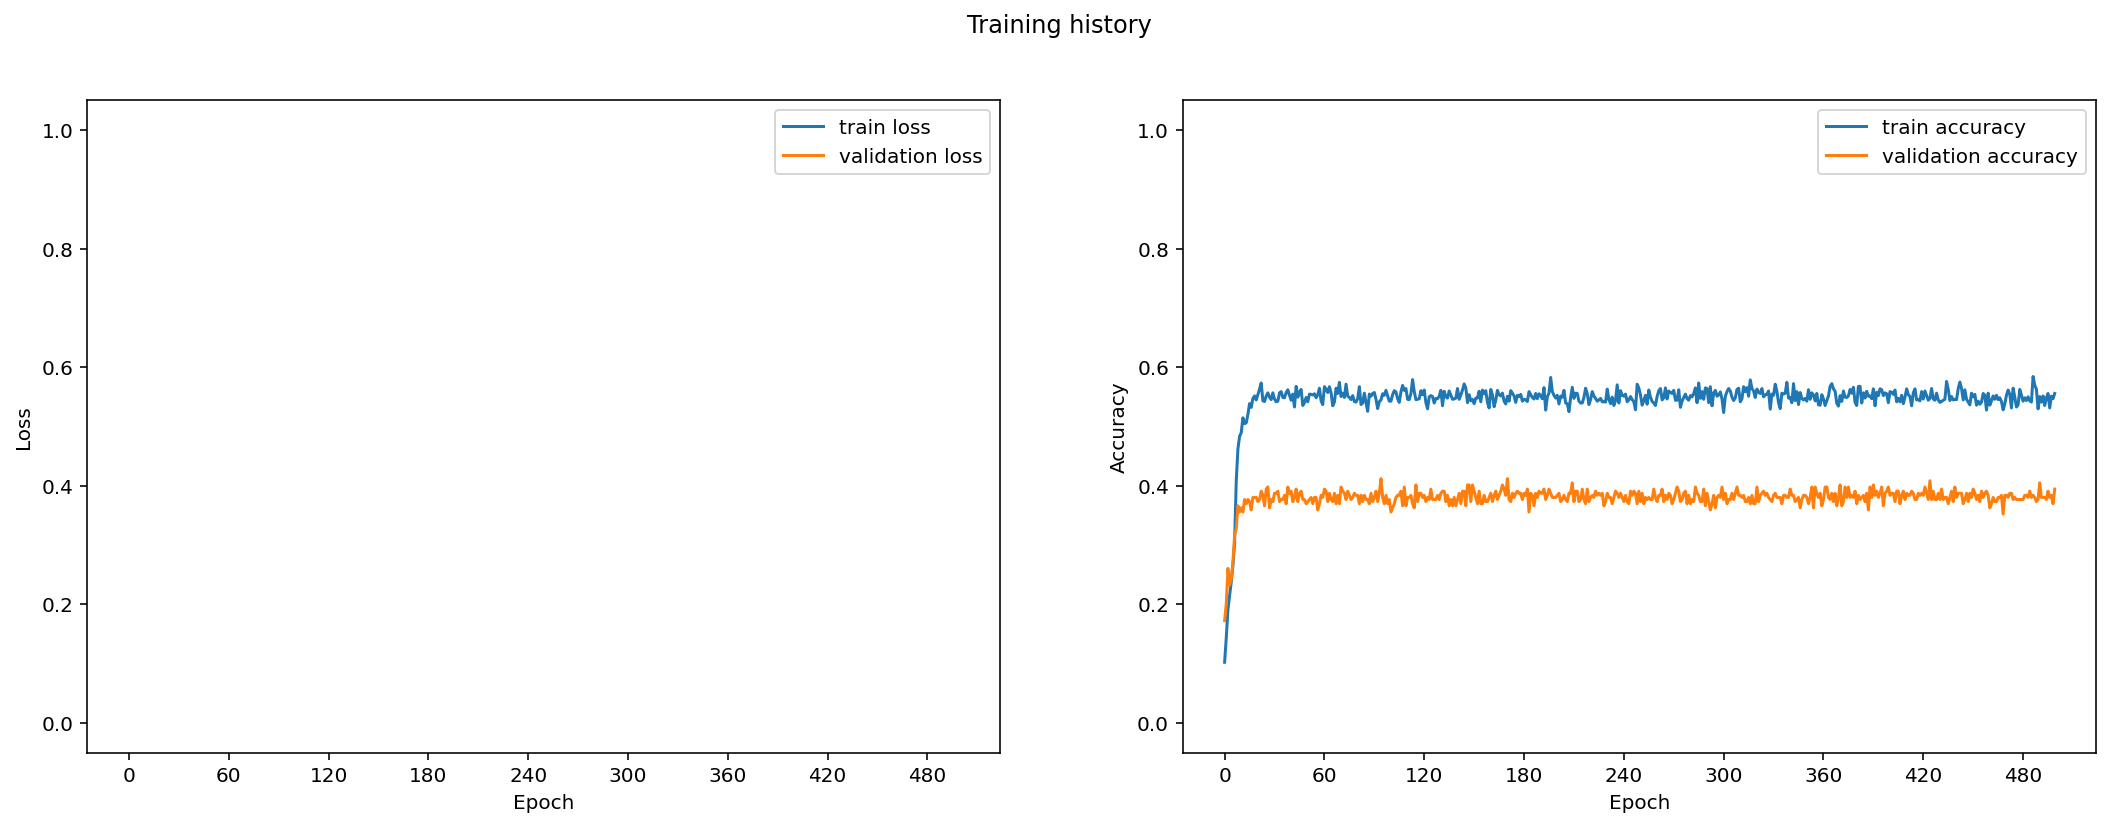

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  fig.suptitle('Training history')
plot_training_history(history)

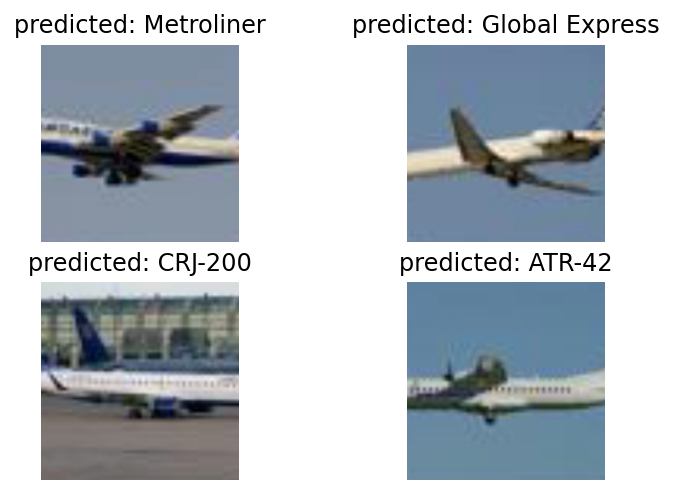

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return
show_predictions(base_model, class_names, n_images=4)

# Testing Metrics

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [ ]:
class_names[-1]

'Yak-42'

In [ ]:
class_names[-1]

'Tu-154'

In [ ]:
class_names.pop()

'Yak-42'

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

                     precision    recall  f1-score   support

               A300       1.00      0.25      0.40         4
               A310       0.27      0.75      0.40         4
               A320       0.38      0.21      0.27        14
               A330       0.08      0.12      0.10         8
               A340       0.67      0.53      0.59        15
               A380       0.00      0.00      0.00         4
             ATR-42       0.38      0.75      0.50         4
             ATR-72       0.29      0.50      0.36         4
              An-12       0.75      0.75      0.75         4
            BAE 146       0.88      0.88      0.88         8
            BAE-125       0.43      0.75      0.55         4
    Beechcraft 1900       0.50      0.25      0.33         4
         Boeing 707       0.29      0.18      0.22        11
         Boeing 717       0.50      1.00      0.67         4
         Boeing 727       0.50      0.50      0.50         4
         Boeing 737    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):
  cm = confusion_matrix.copy()
  cell_counts = cm.flatten()
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

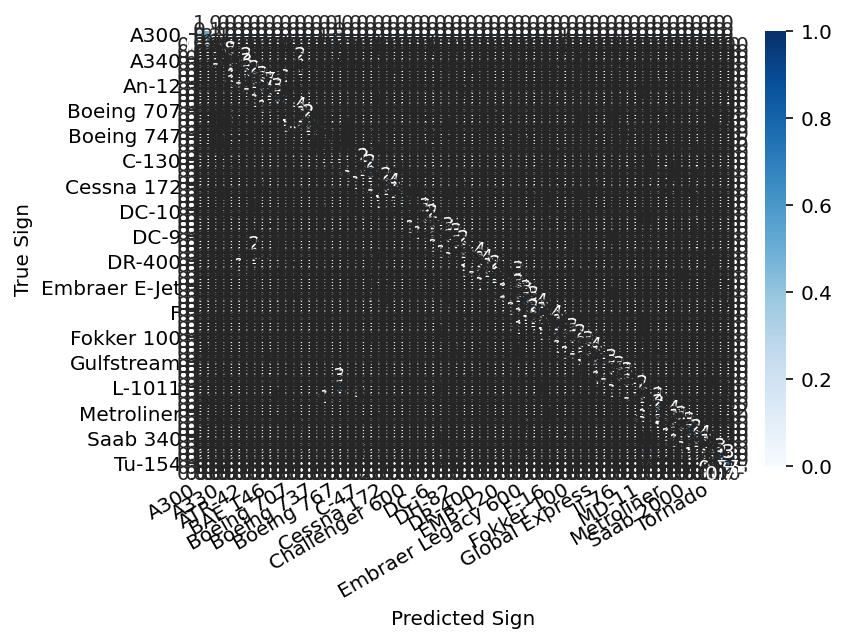

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)